In [117]:
import pickle 
import matplotlib.pyplot as plt 
import numpy as np
import cv2
import sys
sys.path.append('/home/zichaohu/catkin_ws/src/SocialNavigation/scripts')
from processing_utils import *
sys.path.append('/home/zichaohu/catkin_ws/src/SocialNavigation/BCSAN_new')
sys.path.append('/home/zichaohu/catkin_ws/src/SocialNavigation/third_party/neural-astar/src')
sys.path.append('/home/zichaohu/catkin_ws/src/SocialNavigation/third_party/segmentation_models.pytorch')
sys.path.append('/home/zichaohu/catkin_ws/src/SocialNavigation/scripts')

from bc_new import BCNew
from processing_utils import *
import time 
import torchvision
import torch 
import torch.nn as nn
import numpy as np
import glob 
import json
import sys 

In [118]:
DEVICE = "cuda:0"
class BCNew_Ported(nn.Module):
    def __init__(self, exp_num):
        super(BCNew_Ported, self).__init__()
        # exp 15-18
        self.global_planner = BCNew(exp_num=exp_num, Tmax=1000).global_planner
        self.scale = BCNew(exp_num=exp_num, Tmax=1000).scale
        self.exp_num = exp_num
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, lidar_scans):
        map_design = lidar_scans[:,-2:-1] #bug
        guidance_map = self.global_planner(lidar_scans)
        cost_map = torch.clamp(map_design + self.tanh(guidance_map), 0, 1) * self.scale 
        return cost_map 

In [119]:
def load_model(exp_num, MODEL_DIR):
    COUNT = exp_num
    model = BCNew_Ported(exp_num=COUNT)
    
    dict = torch.load(MODEL_DIR, map_location=DEVICE)['state_dict']
    new_dict = {}
    for k,v in dict.items():
        if "vanilla_astar" in k or "diff_astar" in k:
            continue 
        new_dict[k] = v
    model.load_state_dict(new_dict)
    model.eval()
    return model.to(DEVICE)

In [120]:
exp_num = 7
MODEL_DIR = "/robodata/zichaohu/training/BCNew/{}/ahg/".format(exp_num)
check_point = "ahg_pred-epoch=195-val_loss=0.00111.ckpt" # ahg exp 7
# MODEL_DIR = "/robodata/zichaohu/training/BCNew/{}/".format(exp_num)
# check_point = "pred-epoch=111-val_loss=0.00442.ckpt" # exp 6
model = load_model(exp_num,MODEL_DIR+check_point)

255.0
torch.Size([1, 5, 256, 256]) torch.Size([1, 1, 256, 256])
tensor([[120, 203]], device='cuda:0')
(2,)


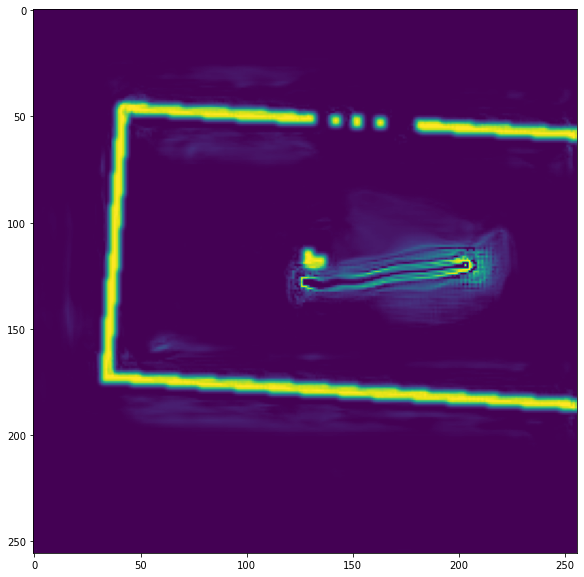

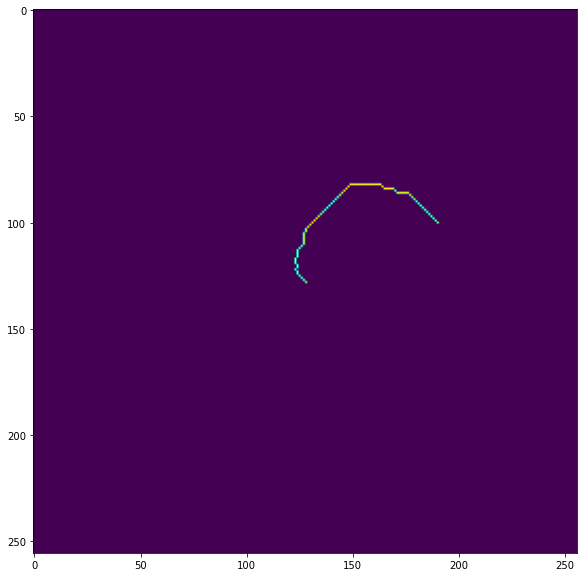

In [121]:
with open("pkl/sim_{}.pkl".format(20), "rb") as f:
    input_map, cost_map = pickle.load(f)
lidar_scans = input_map[:-5]


lidar_scans = torch.tensor(lidar_scans).to(DEVICE)
lidar_scans = lidar_scans.view(1,6,256,256)

past_img = visualize_multi_channel_img(lidar_scans[0,:5].cpu().numpy(), discount_val=0.3,is_normalized=True)
past_img = np.clip(past_img,0,255)
print(np.max(past_img))
goal_idx = torch.nonzero(lidar_scans[0,-1])
goal_map = torch.zeros([1,1,256,256]).to(DEVICE)
goal_map[0,0,100,190] = 1
scan = lidar_scans[:,:5]
print(scan.shape, goal_map.shape)
# lidar_scans = torch.cat([scan, goal_map], dim=1)
print(goal_idx)
gb_kernel = torchvision.transforms.GaussianBlur(5, 1.1)
lidar_scans = gb_kernel(lidar_scans)
# lidar_scans[0,:5] = 0
# tmp = lidar_scans
# lidar_scans[0,0] = tmp[0,4]
# lidar_scans[0,1] = tmp[0,4]
# lidar_scans[0,2] = tmp[0,4]
# lidar_scans[0,3] = tmp[0,4]

cost_map = model(lidar_scans)
# cost_map[cost_map<10] = 0

model4_start_img = np.zeros([256,256])
model4_start_img[128,128] = 1
model4_goal_map = np.zeros([256,256])
model4_goal_map[100,190] = 1
my_cost = cost_map[0,0].detach().cpu().numpy()
print(goal_idx[0].cpu().numpy().shape)
history_map, path_map, path= solve_single(my_cost, model4_start_img, model4_goal_map, np.ones([256,256]))

plt.figure(figsize=[10,10])
plt.imshow(cost_map[0,0].detach().cpu())
plt.show()
plt.figure(figsize=[10,10])

plt.imshow(path_map)

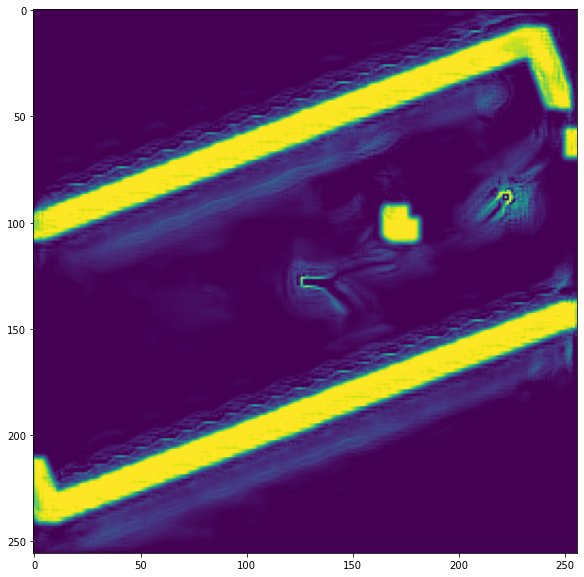

In [40]:
with open("pkl/sim_{}.pkl".format(57), "rb") as f:
    input_map, cost_map = pickle.load(f)
    input_map = input_map[:-5]
    cost_map = cost_map[:-5]
    input_map = input_map.reshape(6,256,256)
    model4_curr_map = input_map[-2]
    model4_goal_map = input_map[-1]
    model4_cost_map = cost_map.reshape(256,256)
    model4_start_img = np.zeros([256,256])
    model4_start_img[128,128] = 1
plt.figure(figsize=[10,10])
plt.imshow(model4_cost_map)

In [49]:
import sys 
from pqdict import pqdict

import torch

In [50]:

def get_neighbor_indices(idx: int, H: int, W: int) -> np.array:
    """Get neighbor indices"""

    neighbor_indices = []
    if idx % W - 1 >= 0:
        neighbor_indices.append(idx - 1)
    if idx % W + 1 < W:
        neighbor_indices.append(idx + 1)
    if idx // W - 1 >= 0:
        neighbor_indices.append(idx - W)
    if idx // W + 1 < H:
        neighbor_indices.append(idx + W)
    if (idx % W - 1 >= 0) & (idx // W - 1 >= 0):
        neighbor_indices.append(idx - W - 1)
    if (idx % W + 1 < W) & (idx // W - 1 >= 0):
        neighbor_indices.append(idx - W + 1)
    if (idx % W - 1 >= 0) & (idx // W + 1 < H):
        neighbor_indices.append(idx + W - 1)
    if (idx % W + 1 < W) & (idx // W + 1 < H):
        neighbor_indices.append(idx + W + 1)

    return np.array(neighbor_indices)


def compute_chebyshev_distance(idx: int, goal_idx: int, W: int) -> float:
    """Compute chebyshev heuristic"""

    loc = np.array([idx % W, idx // W])
    goal_loc = np.array([goal_idx % W, goal_idx // W])
    dxdy = np.abs(loc - goal_loc)
    h = dxdy.sum() - dxdy.min()
    euc = np.sqrt(((loc - goal_loc) ** 2).sum())
    return h + 0.001 * euc


def get_history(close_list: list, H: int, W: int) -> np.array:
    """Get search history"""

    history = np.array([[idx % W, idx // W] for idx in close_list.keys()])
    history_map = np.zeros((H, W))
    history_map[history[:, 1], history[:, 0]] = 1

    return history_map


def backtrack(parent_list: list, goal_idx: int, H: int, W: int) -> np.array:
    """Backtrack to obtain path"""

    current_idx = goal_idx
    path = []
    while current_idx != None:
        path.append([current_idx % W, current_idx // W])
        current_idx = parent_list[current_idx]
    path = np.array(path)
    path_map = np.zeros((H, W))
    path_map[path[:, 1], path[:, 0]] = 1

    return path_map, path

def solve_single(
    pred_cost: np.array,
    start_map: np.array,
    goal_map: np.array,
    map_design: np.array,
    g_ratio: float = 0.5,
) -> list:
    """Solve a single problem"""

    H, W = map_design.shape
    start_idx = np.argwhere(start_map.flatten()).item()
    goal_idx = np.argwhere(goal_map.flatten()).item()
    map_design_vct = map_design.flatten()
    pred_cost_vct = pred_cost.flatten()
    open_list = pqdict()
    close_list = pqdict()
    open_list.additem(start_idx, 0)
    parent_list = dict()
    parent_list[start_idx] = None

    num_steps = 0
    while goal_idx not in close_list:
        if len(open_list) == 0:
            print("goal not found")
            return np.zeros_like(goal_map), np.zeros_like(goal_map)
        num_steps += 1
        v_idx, v_cost = open_list.popitem()
        close_list.additem(v_idx, v_cost)
        for (id, n_idx) in enumerate(get_neighbor_indices(v_idx, H, W)):
            if id < 4:
                step_cost = 1
            else:
                step_cost = np.sqrt(2)
            if map_design_vct[n_idx] == 1:
                f_new = (
                    v_cost
                    - (1 - g_ratio)
                    * compute_chebyshev_distance(v_idx, goal_idx, W)
                    + g_ratio * pred_cost_vct[n_idx]
                    + (1 - g_ratio) * compute_chebyshev_distance(n_idx, goal_idx, W)
                    + step_cost
                )

                # conditions for the nodes not yet in the open list nor closed list
                cond = (n_idx not in open_list) & (n_idx not in close_list)

                # condition for the nodes already in the open list but with larger f value
                if n_idx in open_list:
                    cond = cond | (open_list[n_idx] > f_new)

                if cond:
                    try:
                        open_list.additem(n_idx, f_new)
                    except:
                        open_list[n_idx] = f_new
                    parent_list[n_idx] = v_idx

    history_map = get_history(close_list, H, W)
    path_map, path = backtrack(parent_list, goal_idx, H, W)
    return history_map, path_map, path